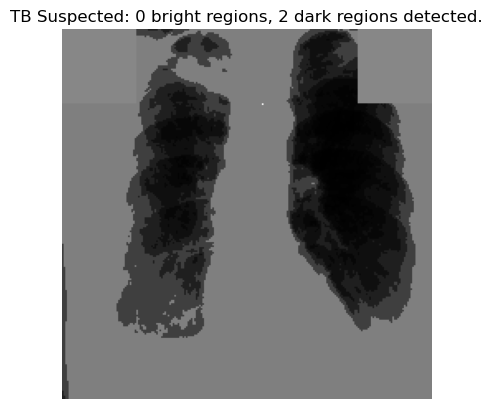

TB Suspected: 0 bright regions, 2 dark regions detected.


In [76]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Constants
RESIZE_SHAPE = (224, 224)
avg_train_intensity = (0.531459229, 0.531459229, 0.531459229)
avg_mask = np.zeros((*RESIZE_SHAPE, 3))
black_mask = np.zeros((*RESIZE_SHAPE, 3))

# Create masks
for r in range(len(avg_mask)):
    for c in range(len(avg_mask[0])):
        if r < 45 and (c < 45 or c > 178):  # Upper corners
            avg_mask[r][c] = avg_train_intensity
            black_mask[r][c] = (0, 0, 0)
        else:
            black_mask[r][c] = (1, 1, 1)

# Function to detect padding
def is_padding(row):
    for i in range(6):
        if not np.count_nonzero(np.subtract(row, i)):
            return True
    for i in range(250, 256):
        if not np.count_nonzero(np.subtract(row, i)):
            return True
    return False

# Preprocessing function
def preprocess_image(image_path, image_size=RESIZE_SHAPE):
    # Read the image and extract the blue channel
    image_color = cv2.imread(image_path, 1)
    b, _, _ = cv2.split(image_color)
    height, width = b.shape
    image = b.copy()

    # Remove padding (rows and columns)
    min_y, max_y = 0, height - 1
    for row in image:
        if is_padding(row):
            min_y += 1
        else:
            break
    for row_index in range(height - 1, 0, -1):
        if is_padding(image[row_index]):
            max_y -= 1
        else:
            break
    min_x, max_x = 0, width - 1
    for col in image.T:
        if is_padding(col):
            min_x += 1
        else:
            break
    for col_index in range(width - 1, 0, -1):
        if is_padding(image.T[col_index]):
            max_x -= 1
        else:
            break

    # Crop the image
    image = image[min_y:max_y, min_x:max_x]
    image = cv2.merge([image, image, image])  # Convert back to 3-channel

    # Resize the image
    image = cv2.resize(image, image_size, interpolation=cv2.INTER_LANCZOS4)

    # Normalize image intensities
    min_value = np.min(image)
    max_value = np.max(image)
    image = (image - min_value) / (max_value - min_value)

    # Apply black_mask and avg_mask
    image = cv2.bitwise_and(image, black_mask)
    image = cv2.addWeighted(image, 1, avg_mask, 1, 0)

    # Re-normalize the image
    min_value = np.min(image)
    max_value = np.max(image)
    image = (image - min_value) / (max_value - min_value)

    return image

# Algorithm to detect TB-like patterns
def detect_tb_patterns(image):
    gray_image = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Threshold for bright regions (e.g., consolidations)
    _, bright_regions = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)

    # Threshold for dark regions (e.g., cavitations)
    _, dark_regions = cv2.threshold(gray_image, 50, 255, cv2.THRESH_BINARY_INV)

    # Find contours of bright regions
    bright_contours, _ = cv2.findContours(bright_regions, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find contours of dark regions
    dark_contours, _ = cv2.findContours(dark_regions, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Analyze regions
    bright_count = 0
    dark_count = 0
    for contour in bright_contours:
        area = cv2.contourArea(contour)
        if area > 50:  # Filter small regions
            bright_count += 1

    for contour in dark_contours:
        area = cv2.contourArea(contour)
        if area > 50:  # Filter small regions
            dark_count += 1

    return bright_count, dark_count

# Process and analyze the image
processed_img = preprocess_image("assets/Tuberculosis-2.png")
bright_count, dark_count = detect_tb_patterns(processed_img)

# Determine diagnosis
if bright_count == 0 and dark_count == 0:
    diagnosis = "Healthy Lungs"
else:
    diagnosis = f"TB Suspected: {bright_count} bright regions, {dark_count} dark regions detected."

# Display the results
plt.imshow(processed_img)
plt.axis("off")
plt.title(f"{diagnosis}")
plt.show()

print(diagnosis)
